In [32]:
# Import libraries
import keras
from keras.datasets import mnist
from keras.layers import Dense
from keras.models import Sequential
import matplotlib.pyplot as plt
import random
from random import randint
import numpy as np

11490434/11490434 [==============================] - 1s 0us/step


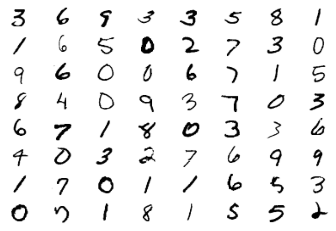

In [2]:
# Preparing the dataset
# Setup train and test splits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Making a copy before flattening for the next code-segment which displays images
x_train_drawing = x_train

image_size = 784 # 28 x 28
x_train = x_train.reshape(x_train.shape[0], image_size) 
x_test = x_test.reshape(x_test.shape[0], image_size)

# Convert class vectors to binary class matrices
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Show some random digits
for i in range(64):
    ax = plt.subplot(8, 8, i+1)
    ax.axis('off')
    plt.imshow(x_train_drawing[randint(0, x_train.shape[0])], cmap='Greys')

In [20]:
print(y_train[1][0])

1.0


In [34]:
X_data = x_test/255.0
y = []
for i in range(0,len(y_test)):
    if y_test[i][0] == 1:
        y.append(1)
    else:
        y.append(-1)
y = np.array(y)
y = y.reshape(y.shape[0], 1)
print(y.shape)
print(y)

(10000, 1)
[[-1]
 [-1]
 [-1]
 ...
 [-1]
 [-1]
 [-1]]


In [35]:
# Define cost functions

# Condition metric
def H(X, y, theta):
    y = y.reshape(y.shape[0], 1) # change to 2d array
    return (1 - y * (X@theta))

# SVM loss function
def svm_loss_re(X, y, theta, lamda):
    h = H(X, y, theta)
    penalty = lamda*(theta.T @ theta)
    loss = np.mean([max(0, i) for i in h])
    return np.asscalar(penalty) + np.asscalar(loss) 

# Gradient of SVM loss function
def svm_grad_re(X, y, theta, lamda):
    h = H(X, y, theta)
    y = y.reshape(y.shape[0], 1) # change to 2d array
    cond = np.array([(i > 0)*1 for i in h])
    return 2*lamda*theta - X.T @ (y*cond)/y.shape[0]


In [36]:
#Split dataset to num_worker workers
def split_workers(X_data, y_data, num_worker):
    # Split into 10 subdatasets for 10 workers
    data_X_list=[]
    data_y_list=[]
    num_data = len(y_data)
    num_per_data = num_data // num_worker
    for i_th in range(num_worker):
        j = num_per_data * (i_th + 1)
        i = i_th*num_per_data
        x_data_worker = X_data[i:j]
        y_data_worker = y_data[i:j]
        data_X_list.append(x_data_worker)
        data_y_list.append(y_data_worker)
        
    return data_X_list, data_y_list

# Function to train master-worker
def train(X_data, y, num_worker, num_iter, var, pLevel, lamda, alpha, lr_fade=1):
    
    # lamda: penalty
    # alpha: learning rate
    # var: noise variance
    # pLevel: noise adding probability
    # num_iter: number of iterations
    
    # Split into 10 subdatasets for 10 workers
    data_X_list, data_y_list = split_workers(X_data, y, num_worker)
    
    # train
    weight = np.random.rand(X_data.shape[1], 1)
    total_loss_list=[]
    for i_iter in range(num_iter):
        gradient_list=[]
        # Fill in
        for j_worker in range(num_worker):
            # call data_j from worker j
            X_worker = data_X_list[j_worker]
            y_worker =data_y_list[j_worker]
            # get grad from worker j
            grad = svm_grad_re(X_worker, y_worker, weight, lamda)
            # add noise
            noise = np.random.normal(0, var)
            pro = random.uniform(0,1)
            grad = grad + noise * (pro <= pLevel)
            gradient_list.append(grad)
        # Fill in
        grad_ave = 1./num_worker*sum(gradient_list)
        alpha *= lr_fade
        weight -= alpha * grad_ave
        total_loss_list.append(svm_loss_re(X_data, y, weight, lamda))
    
    return total_loss_list

In [37]:
# Tune noise and consider ? iterations
def tuningNoise(var, pLevel):
    return train(X_data, y, num_worker = 10, num_iter = 200, var = var, pLevel = pLevel, lamda = 0.03, alpha = 0.02, lr_fade = 1)

In [7]:
print(y_train)

[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


#Convergence against R (Master-worker)#

/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
<ipython-input-35-0342074f4a69>:13: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  return np.asscalar(penalty) + np.asscalar(loss)


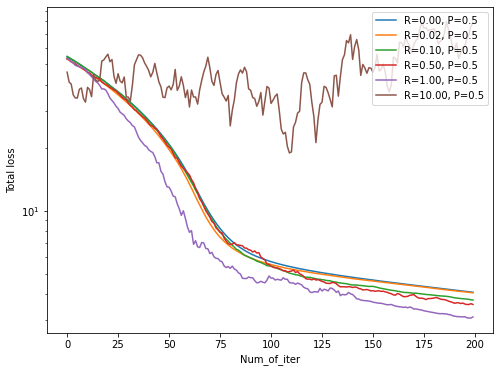

In [38]:
# pLevel = ?; num_iter = ?
Loss_var = []
varList = [0, 0.02, 0.1, 0.5, 1, 10]
for i in varList:
    # Fill in
    Loss_var.append(tuningNoise(var=i, pLevel=0.5))

%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 8, 6

x_axis = np.arange(0, 200)
for i in range(len(Loss_var)):
    plt.semilogy(x_axis, Loss_var[i], label='R=%.2f, P=0.5' % (varList[i]))
    
plt.xlabel('Num_of_iter')
plt.ylabel('Total loss')
plt.legend(loc='upper right', prop={'size': 10 })
plt.savefig('Figure.png')
plt.show()

In [57]:
# var = 1; num_iter = 200
Loss_p = []
pList = [0.02, 0.1, 1]
for i in pList:
    Loss_p.append(tuningNoise(var=1, pLevel=i))

<ipython-input-35-0342074f4a69>:13: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  return np.asscalar(penalty) + np.asscalar(loss)


#Convergence against P (Master-worker)#




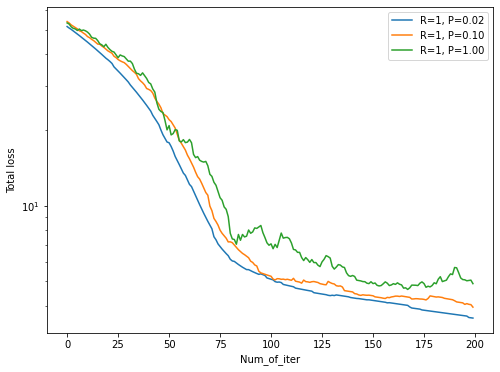

In [58]:
x_axis = np.arange(0, 200)
for i in range(len(Loss_p)):
    plt.semilogy(x_axis, Loss_p[i], label='R=1, P=%.2f' % (pList[i]))
    
plt.xlabel('Num_of_iter')
plt.ylabel('Total loss')
plt.legend(loc='upper right', prop={'size': 10})
plt.savefig('M-w_p.png')
plt.show()

In [41]:
# lamda: penalty
# alpha: learning rate
# var: noise variance
# pLevel: noise adding probability
# num_iter: number of iterations
def train_star(X_data, y, num_worker_left, num_worker_right, num_iter, var, pLevel, lamda, alpha, lr_fade):
    # Split into 10 subdatasets for 10 workers
    data_X_list=[]
    data_y_list=[]
    
    w_init = np.random.rand(X_data.shape[1], 1)
    weight, weight_left, weight_right = w_init, w_init, w_init
    
    total_loss_list = []
    
    num_data = len(y)
    num_worker = num_worker_left + num_worker_right
    num_per_data = num_data // num_worker
    for i_th in range(num_worker):
        j = num_per_data * (i_th + 1)
        i = i_th*num_per_data
        x_data_worker = X_data[i:j]
        y_data_worker = y[i:j]
        data_X_list.append(x_data_worker)
        data_y_list.append(y_data_worker)
       
    for i_iter in range(num_iter):
        #left topo
        gradient_list_left, gradient_list_right = [], []
        for j_worker in range(num_worker_left):
            #call data_j from worker j
            X_worker = data_X_list[j_worker]
            y_worker =data_y_list[j_worker]
            # get grad from left topo worker j
            grad = svm_grad_re(X_worker, y_worker, weight, lamda)
            noise = np.random.normal(0, var)
            pro = random.uniform(0,1)
            grad = grad + noise * (pro>=pLevel)
            gradient_list_left.append(grad)
        #updata weight with average grad for left branch workers
        alpha *= lr_fade
        weight_left -= alpha * 1./num_worker*sum(gradient_list_left)
        
        #right topo
        for j_worker in range(num_worker_left, num_worker):
            #call data_j from worker j
            X_worker = data_X_list[j_worker]
            y_worker =data_y_list[j_worker]
            # get grad from right topo worker j
            grad = svm_grad_re(X_worker, y_worker, weight, lamda)
            noise = np.random.normal(0, var)
            pro = random.uniform(0,1)
            grad = grad + noise * (pro>=pLevel)
            gradient_list_right.append(grad)
        #updata weight with average grad for left branch workers
        alpha *= lr_fade
        weight_right -= alpha * 1./num_worker*sum(gradient_list_left)
        
        #upodate weight based on weight_left and weight_right
        weight = 1/2*(weight_left + weight_right)
        
        total_loss_list.append(svm_loss_re(X_data, y, weight,lamda))
        
    return total_loss_list

In [45]:
# default iterations: 200
def tuningNoise_star(var, pLevel):
    return train_star(X_data, y, num_worker_left=5, num_worker_right=5,num_iter=200, var=var, pLevel=pLevel, lamda=0.03, alpha=0.2, lr_fade=1)
    

In [46]:
Loss_var = []
varList = [0, 0.02, 0.1, 0.5, 1, 10]
for i in varList:
    Loss_var.append(tuningNoise_star(var=i, pLevel=0.5))

/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
<ipython-input-35-0342074f4a69>:13: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  return np.asscalar(penalty) + np.asscalar(loss)


#Convergence against R (Two-star)#

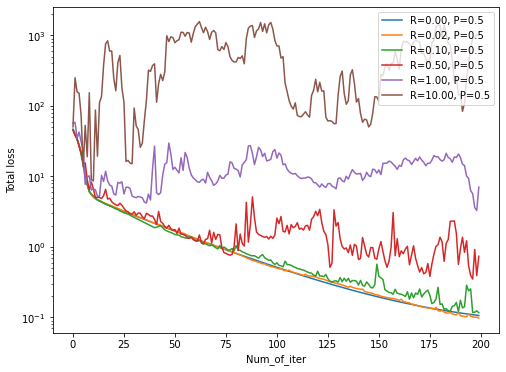

In [48]:
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 8, 6
import matplotlib.pyplot as plt

x_axis = np.arange(0, 200)
for i in range(len(Loss_var)):
    plt.semilogy(x_axis, Loss_var[i], label='R=%.2f, P=0.5' % (varList[i]))
    
plt.xlabel('Num_of_iter')
plt.ylabel('Total loss')
plt.legend(loc='upper right', prop={'size': 10})
plt.savefig('2star_R.png')
plt.show()

In [78]:
Loss_p = []
pList = [0, 0.02, 0.1, 0.5, 1]
for i in pList:
    Loss_p.append(tuningNoise_star(var=0.1, pLevel=i))

<ipython-input-35-0342074f4a69>:13: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  return np.asscalar(penalty) + np.asscalar(loss)


#Convergence against P (Two-star)#

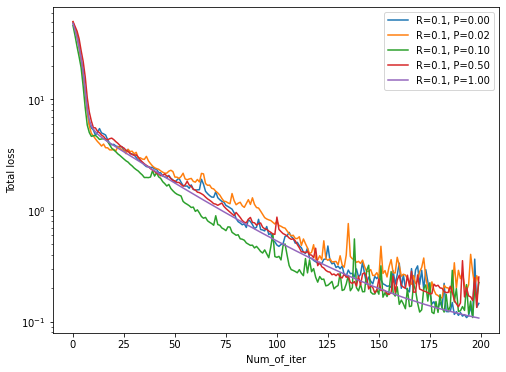

In [79]:
x_axis = np.arange(0, 200)
for i in range(len(Loss_p)):
    plt.semilogy(x_axis, Loss_p[i], label='R=0.1, P=%.2f' % (pList[i]))
    
plt.xlabel('Num_of_iter')
plt.ylabel('Total loss')
plt.legend(loc='upper right', prop={'size': 10})
plt.savefig('2star_p.png')
plt.show()